In [1]:
# set to True if in colab
in_colab = False
floatType = 32
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
if floatType == 16:
    tf.keras.backend.set_floatx('float16')

In [3]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    checkpoint_filepath = data_dir + "weights_unet_transfer_learning/"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    checkpoint_filepath = data_dir + "weights_unet_transfer_learning/"

## Import model

In [4]:
from models.UNET import UNET
input_shape=(304, 304, 3)
model = UNET(input_shape=input_shape, floatType = floatType, n_classes=3)
model(tf.zeros((32, 304, 304, 3))).shape

TensorShape([32, 304, 304, 3])

In [13]:
model.model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 304, 304, 3) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 304, 304, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 304, 304, 64) 36928       conv2d_76[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 152, 152, 64) 0           conv2d_77[0][0]                  
_______________________________________________________________________________________

## Prepare VOC2012 segmentation data

  1%|▋                                                                              | 26/2912 [00:00<00:11, 253.02it/s]


Loading images and annotations...


100%|█████████████████████████████████████████████████████████████████████████████| 2912/2912 [00:09<00:00, 313.84it/s]



Convert to tensor...


  0%|                                                                                         | 0/1085 [00:00<?, ?it/s]


Done
Images shape: (1085, 304, 304, 3), annotations shape: (1085, 304, 304, 1)
Reshape gt from (width,height,1) to (width,height,n_classes)


100%|█████████████████████████████████████████████████████████████████████████████| 1085/1085 [00:01<00:00, 836.59it/s]


Images shape: (1085, 304, 304, 3), annotations shape: (1085, 304, 304, 3)
Examples:


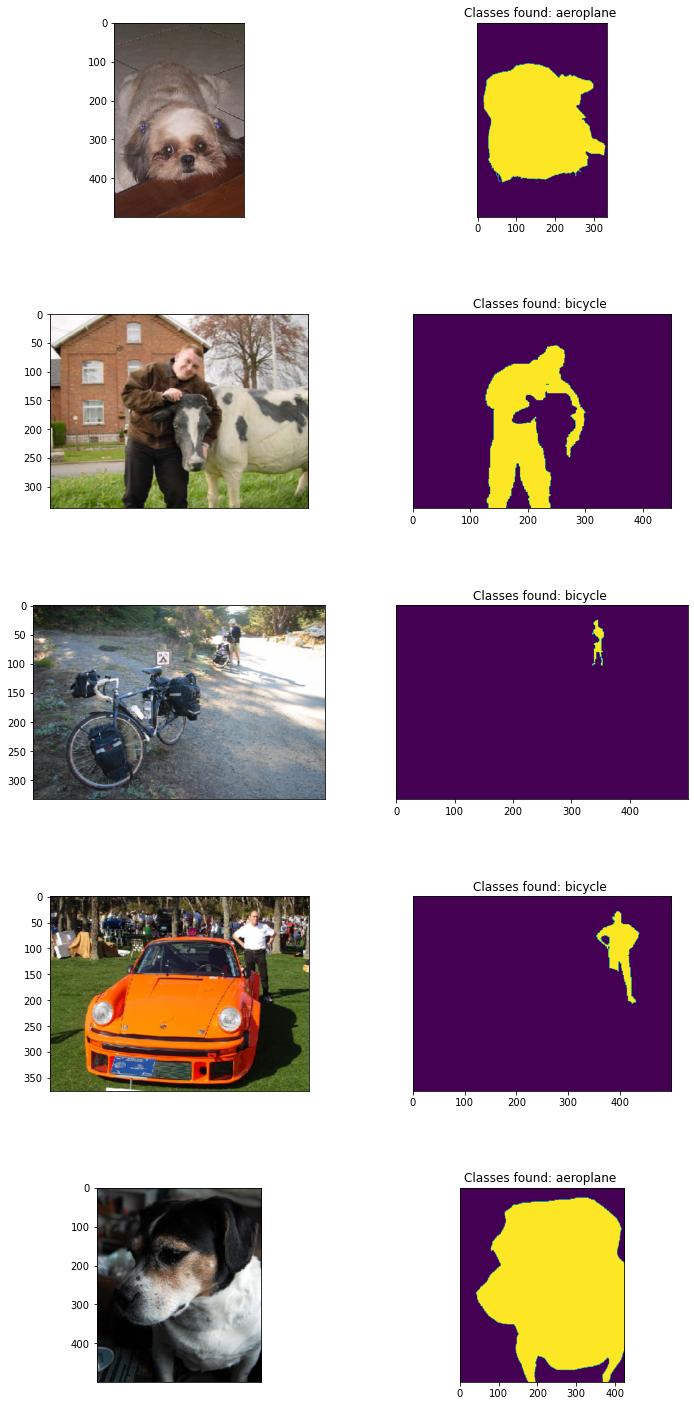

In [5]:
from data_management.VOC2012Manager import VOC2012Manager

manager = VOC2012Manager(floatType = floatType, input_shape=input_shape)
targets = ["person", "dog"]
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(
        VOC2012_path=VOC2012_path,
        n_samples_to_show=5,
        targets=targets,
        last_data_idx=last_data_idx)

In [6]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [7]:
# verify train val shapes
for train_img, train_annot in train_dataset:
    break
for val_img, val_annot in val_dataset:
    break
print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")

Train images shape: (32, 304, 304, 3), train annotations shape: (32, 304, 304, 3)
Val images shape: (32, 304, 304, 3), Val annotations shape: (32, 304, 304, 3)


## Train model

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [9]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 2

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.save(data_dir + "unet_final_weights/")